## Data Import and Setup

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
from PIL import Image
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

sns.set(style="whitegrid")
BASE_PATH = "/Users/maxim/Downloads/trainee_dataset"
IMG_SIZE = (244, 244)


We begin by importing all necessary libraries and setting global parameters such as the base path to the dataset and a common image size for preprocessing. Seaborn is configured for a clean visual style in all upcoming plots.  
## Collecting Image Paths and Corresponding Labels

In [2]:
def get_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []
    for label in ['artifacts', 'no artifacts']:
        folder = os.path.join(base_dir, label)
        for img_path in glob(os.path.join(folder, "*.png")):
            image_paths.append(img_path)
            labels.append(str(label))
    return image_paths, labels

train_paths, train_labels = get_image_paths_and_labels(os.path.join(BASE_PATH, "train"))
test_paths, test_labels = get_image_paths_and_labels(os.path.join(BASE_PATH, "test"))

print(f"Train size: {len(train_paths)}, Test size: {len(test_paths)}")

Train size: 1800, Test size: 200


We define a function to extract image file paths and their corresponding labels based on directory structure (class folders named '0' for "no artifacts" and '1' for "artifacts"). The dataset is then split into training and testing subsets with 1800 and 200 images respectively.  
## Class Distribution Visualization  

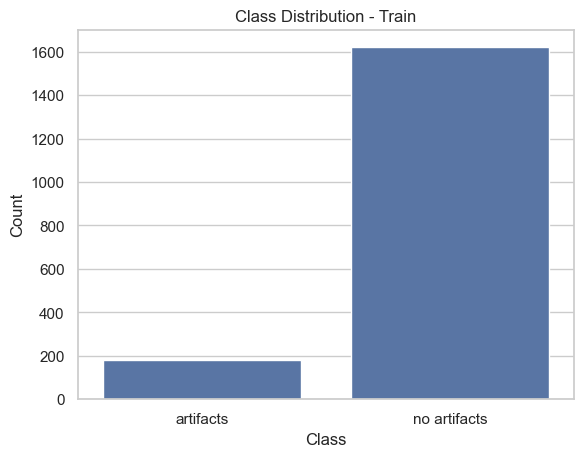

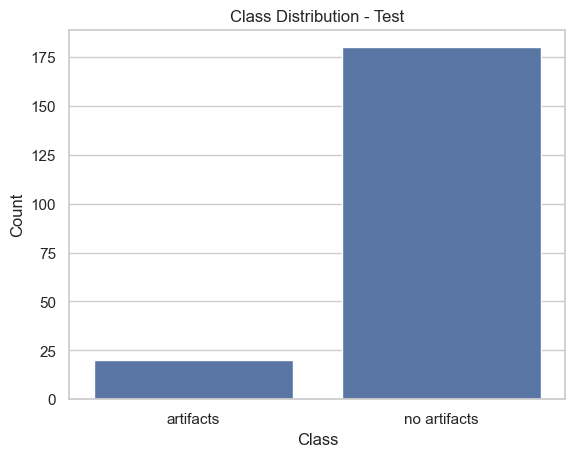

In [3]:
def plot_class_distribution(labels, split_name):
    counter = Counter(labels)
    sns.barplot(x=list(counter.keys()), y=list(counter.values()))
    plt.title(f"Class Distribution - {split_name}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution(train_labels, "Train")
plot_class_distribution(test_labels, "Test")

The dataset is imbalanced, with significantly more images labeled as "no artifacts" (~1600 in training, ~175 in testing) compared to "artifacts" (~200 in training, ~20 in testing). This class imbalance may affect model performance and should be taken into account during training.  
## Visualizing Sample Images (Resized)

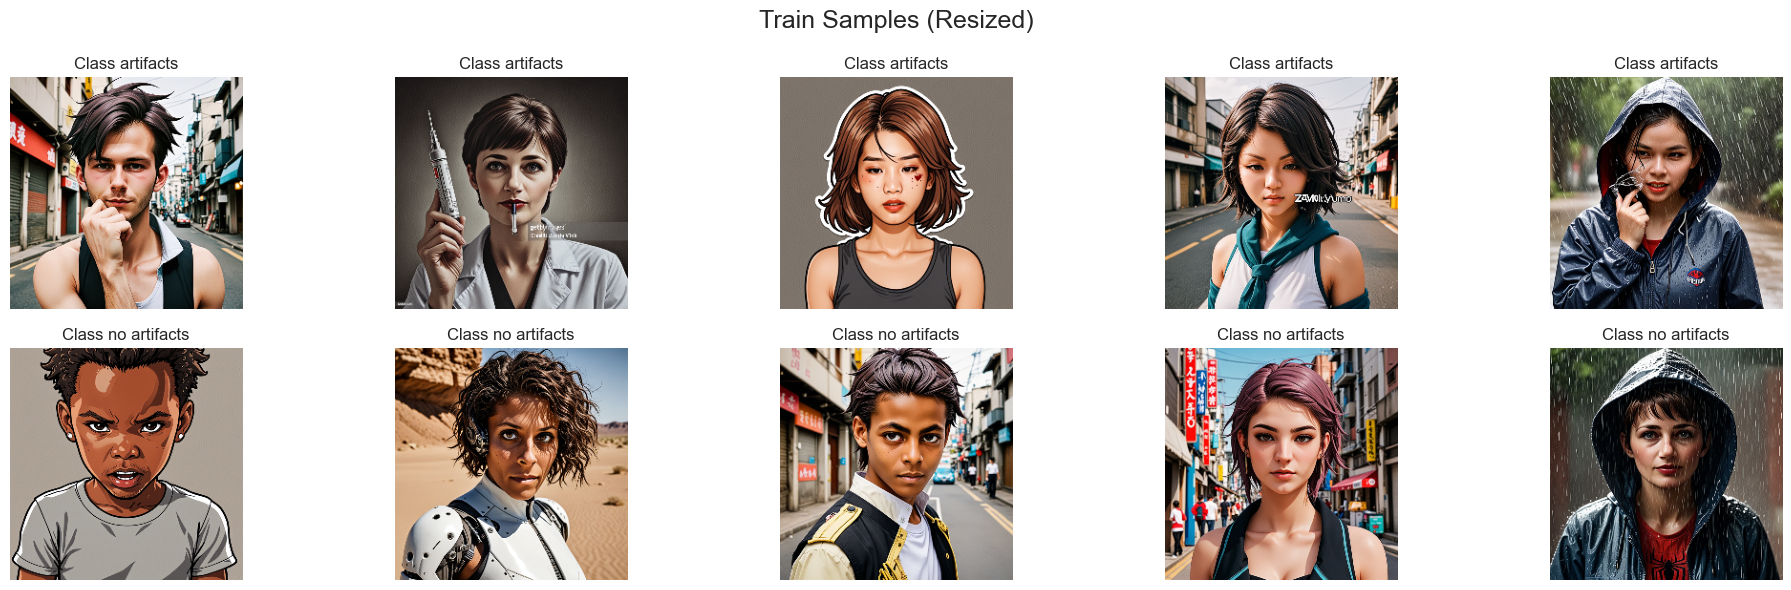

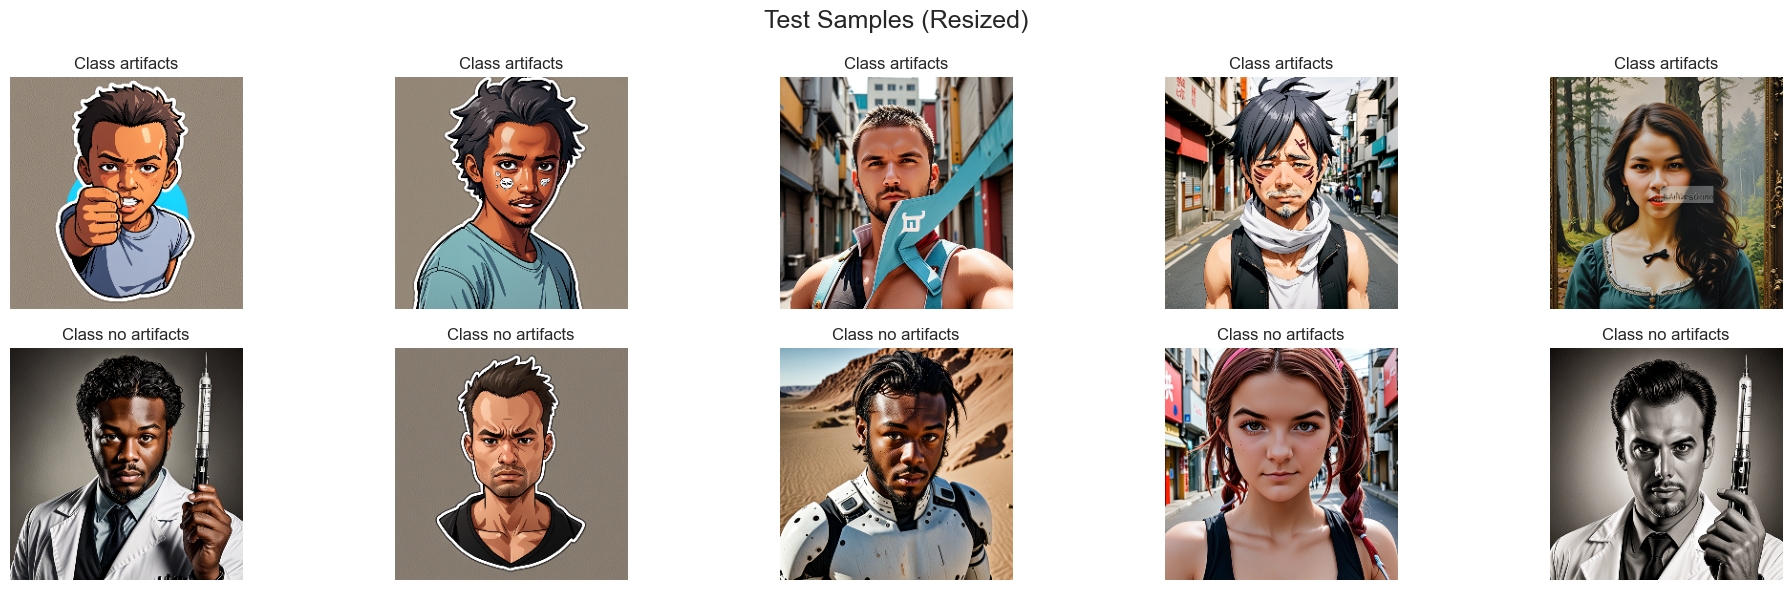

In [4]:
def show_image_samples(image_paths, labels, title, n=5):
    fig, axes = plt.subplots(2, n, figsize=(4 * n, 6))
    fig.suptitle(title, fontsize=18)

    for i, class_label in enumerate(['artifacts', 'no artifacts']):
        class_images = [p for p, l in zip(image_paths, labels) if l == class_label][:n]
        for j, path in enumerate(class_images):
            img = cv2.imread(path)
            img = cv2.resize(img, IMG_SIZE)
            axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i, j].axis('off')
            axes[i, j].set_title(f"Class {class_label}")
    plt.tight_layout()
    plt.show()

show_image_samples(train_paths, train_labels, "Train Samples (Resized)")
show_image_samples(test_paths, test_labels, "Test Samples (Resized)")

A few image samples from each class are displayed after resizing to the target shape. All images appear to be human faces, and the resizing operation preserves essential features.  
## Analyzing Image Size and Brightness Distribution

Image Size Statistics:
        width  height
count  1800.0  1800.0
mean   1024.0  1024.0
std       0.0     0.0
min    1024.0  1024.0
25%    1024.0  1024.0
50%    1024.0  1024.0
75%    1024.0  1024.0
max    1024.0  1024.0

Brightness Statistics:
count    1800.000000
mean       97.210595
std        22.759154
min        49.340467
25%        80.507422
50%        95.097046
75%       115.952447
max       146.878084
dtype: float64


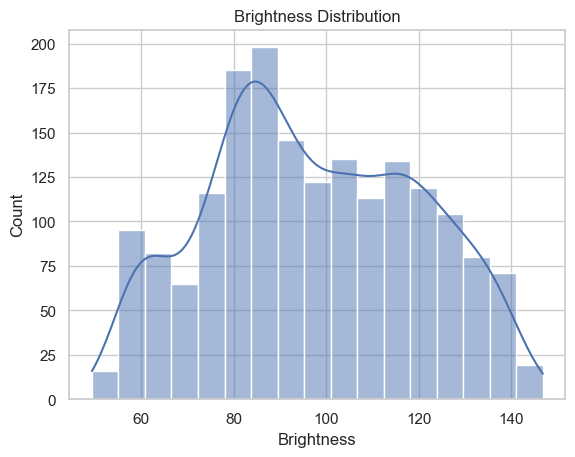

In [5]:
def analyze_image_stats(image_paths):
    sizes = []
    brightness = []

    for path in image_paths:
        img = Image.open(path).convert("L")
        sizes.append(img.size)
        brightness.append(np.array(img).mean())

    size_df = pd.DataFrame(sizes, columns=["width", "height"])
    print("Image Size Statistics:")
    print(size_df.describe())

    print("\nBrightness Statistics:")
    print(pd.Series(brightness).describe())

    sns.histplot(brightness, kde=True)
    plt.title("Brightness Distribution")
    plt.xlabel("Brightness")
    plt.show()

analyze_image_stats(train_paths)

All training images have a consistent size of 1024×1024 pixels. Brightness statistics show a slightly left-skewed distribution, with most images clustered around a brightness value of ~85. The histogram suggests near-normal distribution.  
## Detecting and Removing Duplicate Images

In [ ]:
def check_and_remove_duplicates(image_paths):
    hashes = {}
    duplicates = []

    for path in image_paths:
        img = Image.open(path).resize(IMG_SIZE)
        img_hash = hash(img.tobytes())

        if img_hash in hashes:
            print(f"Duplicate found: {path}, removing...")
            duplicates.append(path)
        else:
            hashes[img_hash] = path

    for dup_path in duplicates:
        try:
            os.remove(dup_path)
        except Exception as e:
            print(f"Failed to delete {dup_path}: {e}")

    print(f"Removed {len(duplicates)} duplicates.")

    return [p for p in image_paths if p not in duplicates]

train_paths = check_and_remove_duplicates(train_paths)

Duplicate images are detected by hashing the byte content of resized images. In this case, 5 duplicate files were found and removed from the dataset, ensuring cleaner data for training.  
## Image Similarity Heatmap 

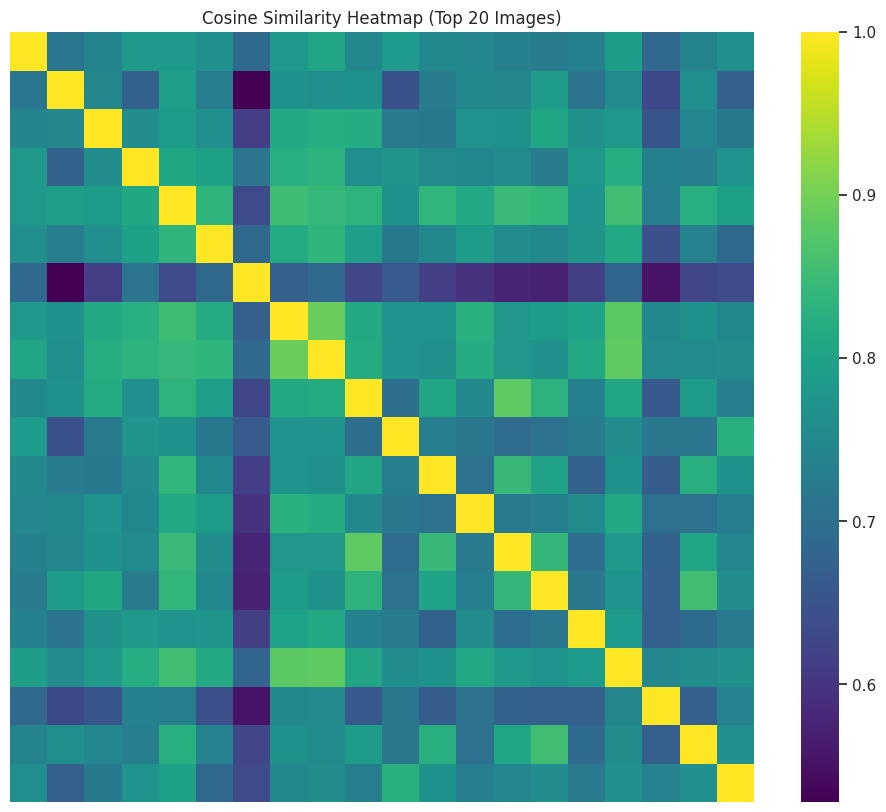

In [10]:
def plot_image_similarity_heatmap(image_paths, n=20):
    selected_paths = image_paths[:n]
    images = []

    for path in selected_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, IMG_SIZE).flatten()
        images.append(img)

    sim_matrix = cosine_similarity(images)

    plt.figure(figsize=(12, 10))
    sns.heatmap(sim_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.title(f"Cosine Similarity Heatmap (Top {n} Images)")
    plt.show()

plot_image_similarity_heatmap(train_paths, n=20)